## DataFrame 작업

### DataFrame 생성

In [ ]:
# 데이터 생성, Row객체 생성
rows = [Row("Matel Zaharia", "CA"), Row("Reynold Xin", "CA")]

# DataFrame 생성
author_df = spark.createDataFrame(rows, ["Authors", "State"])

# DataFrame 출력
author_df.show()

# 스키마 출력, 여기에선 사전 정의된 스키마가 아닌, DataFrame 생성 시 자동 정의된 스키마
author_df.printSchema()

* createDataFrame(): DataFrame 생성<br>
    - 첫 번째 인자로 데이터 전달
    - 두 번째 인자로 스키마를 사전 정의 했을 시 스키마 전달, 사전 정의를 하지 않았을 시 컬럼명 array전달

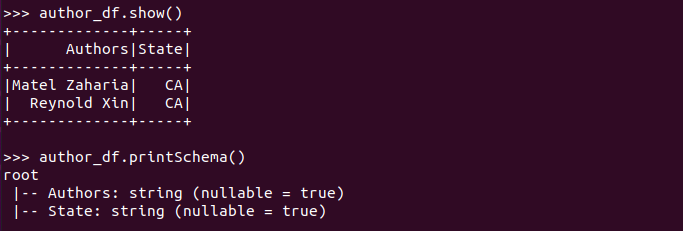

In [ ]:
# 새 터미널에 다음의 코드를 통해 데이터 다운로드
wget https://github.com/FVBros/Spark-The-Definitive-Guide/raw/master/data/flight-data/json/2015-summary.json

In [ ]:
# 다시 spark환경에서 데이터 로드
df = spark.read.format('json').load('/home/ubuntu/2015-summary.json')
df.show()

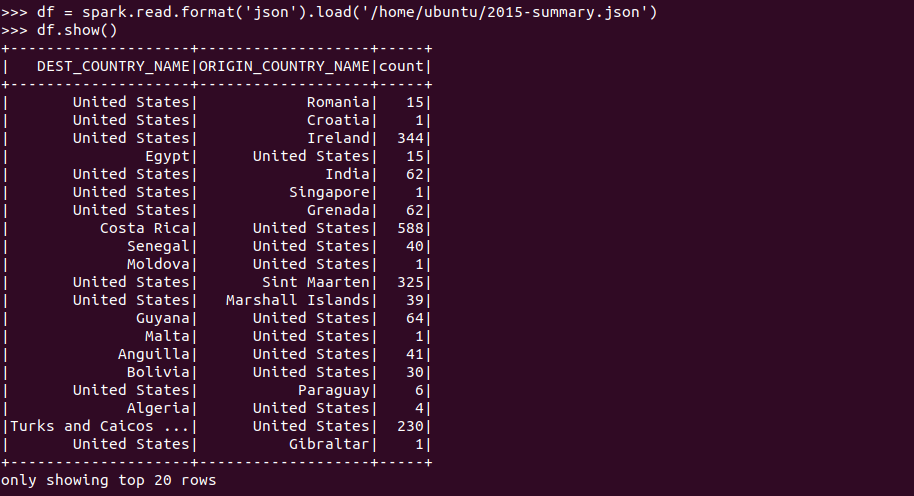

* expr(): 가장 유연한 참조 방법, expr()을 사용하여 SQL로 컬럼명 변경 가능
* alias(): SQL의 'AS'와 유사하게 해당 컬럼의 별칭 지정

In [ ]:
from pyspark.sql.functions import expr

# DEST_COUNTRY_NAME 컬럼의 이름을 destination으로 변경
df.select(expr('DEST_COUNTRY_NAME AS destination')).show(5)

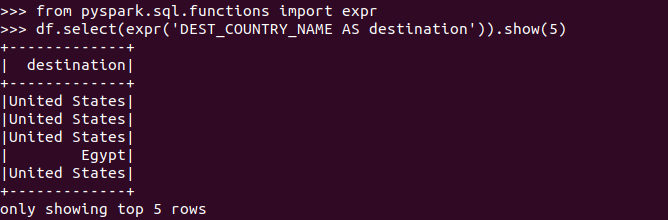

In [ ]:
df.select(expr('DEST_COUNTRY_NAME AS destination').alias('DEST_COUNTRY_NAME')).show(3)

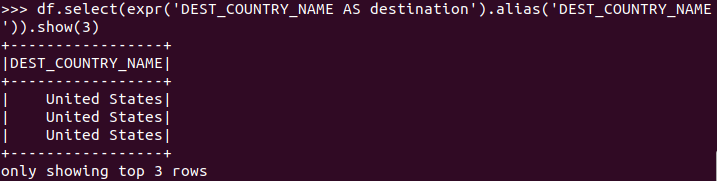

* select()와 expr()을 함께 활용하는 패턴은 자주 사용됨<br>
-> Spark는 이를 더 간단하고 효율적으로 하기 위하여 selectExpr()메소드 제공

In [ ]:
df.selectExpr('DEST_COUNTRY AS destination', 'DEST_COUNTRY_NAME').show(5)

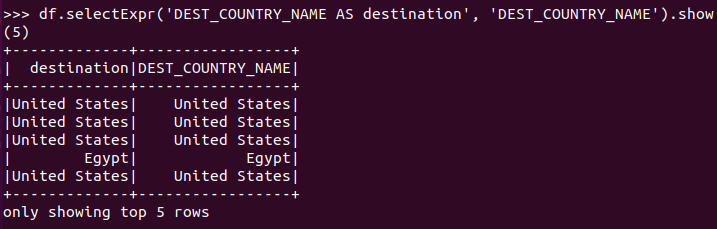

* 이외에도 selectExpr()은 대부분의 비집계형(non-aggregating)SQL 구문들을 사용 가능

In [ ]:
df.selectExpr('*', '(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) AS withinCountry').show(5)

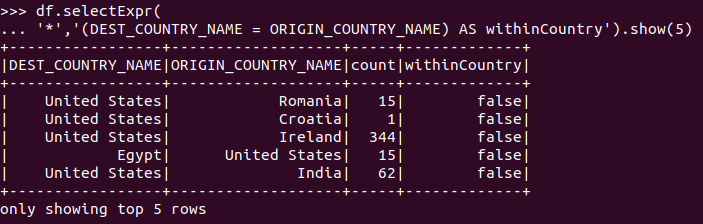

* 집계(SUM, COUNT, AVG, MAX, MIN, ...)에 관련된 연산들은 spark SQL의 집계함수들을 적용하여 사용 가능

In [ ]:
df.selectExpr('avg(count)', 'count(distinct(DEST_COUNTRY_NAME))').show()

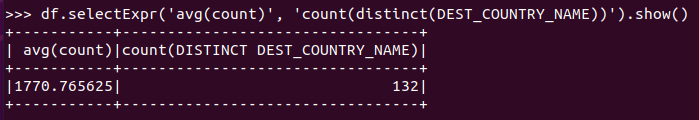

### 값을 Spark 데이터 타입으로 변환

* 데이터 가공 시 컬럼 형식의 데이터가 아니라 상수, 문자열 등 특정 값을 비교, 계산등을 목적으로 DataFrame에 전달해야 하는 경우가 발생 가능 -> 리터럴(literal) 사용
* 리터럴은 프로그래밍 언어(python, scala, ...)의 리터럴값을 Spark가 이해할 수 있는 데이터 타입으로 변환
* 리터럴 또한 일종의 표현식이다.

In [ ]:
from pyspark.sql.functions import lit
df.select(expr('*'), lit(1).alias('One')).show(5)

* lit(): 상기 리터럴을 구현한 메소드

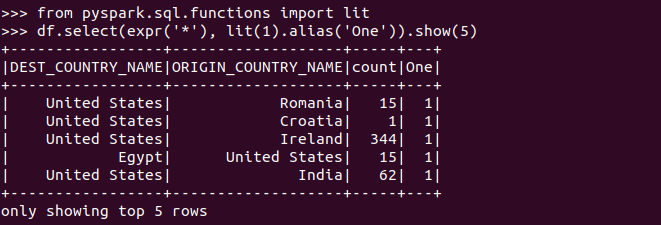

### 컬럼 추가
* selectExpr()을 사용한 방법 이외에도 withColumn()을 사용하여 컬럼 추가 가능
* 인자로 컬럼명과 표현식을 전달

In [ ]:
df.withColumn('withinCountry', expr('ORIGIN_COUNTRY_NAME == DEST_COUNTRY_NAME')).show(5)

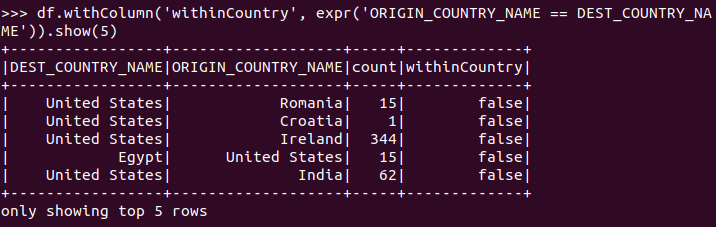

### 컬럼명 변경
* selectExpr()을 사용한 방법 이외에도 withColumnRenamed()을 사용하여 컬럼명 변경 가능
* 인자로 참조할 컬럼명과 바꿀 컬럼명 전달
* columns: DataFrame의 컬럼을 list형태로 변환

In [ ]:
df.withColumnRenamed('DEST_COUNTRY_NAME', 'dset').columns

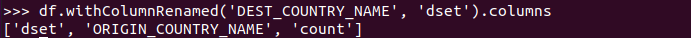

### 예약 문자
* 표현식을 사용하여 컬럼명을 설정할 시에는 공백이나 하이픈(-)과 같은 예약문자를 컬럼명으로 사용 불가능<br>
-> 예약 문자를 컬럼명에 사용하기 위해서는 백틱( ` )을 사용해야 한다.

In [ ]:
# 컬럼명이 표현식이 아닌 문자열로 작성되었으므로 문제 없음
from pyspark.sql.functions import col
dfWithLongColName = df.withColumn(
    'This Long Column-Name'.
    expr('ORIGIN_COUNTRY_NAME'))

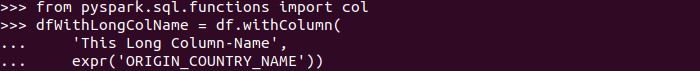

In [ ]:
# 이 둘은 같은 결과 반환
dfWithLongColName.select(col('This Long Column-Name')).columns
dfWithLongColName.select(expr('`This Long Column-Name`')).columns

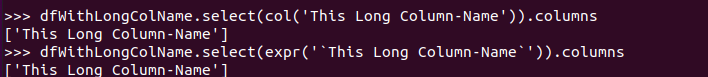

### 컬럼 제거
* pandas와 유사하게 drop()을 사용하여 컬럼 제거
* 데이터 불변성에 따라서 원본 DataFrame에서 컬럼이 제거되는 것은 아님에 주의

In [ ]:
df.drop('ORIGIN_COUNTRY_NAME').columns

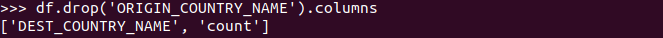

### 컬럼 데이터 타입 변경
* cast() 메소드 사용
* 인자로 변경할 데이터 타입 전달

In [ ]:
df.withColumn('count2', col('count').cast('string')).printSchema()

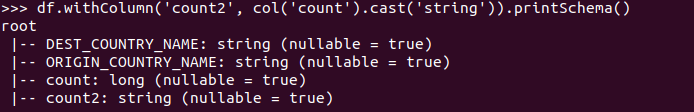

### 필터링
* boolean으로 표현되는 조건문을 만들어 필터링
* where()와 filter()메소드를 사용하여 둘 모두 동일하게 동작

In [ ]:
df.filter(col('count') < 2).show(3)
df.where(col('count') < 2).show(3)

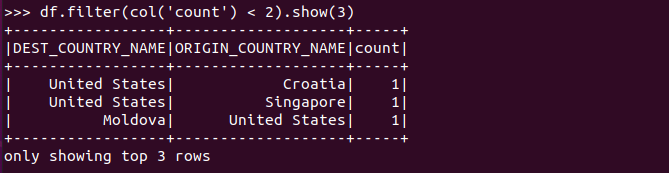

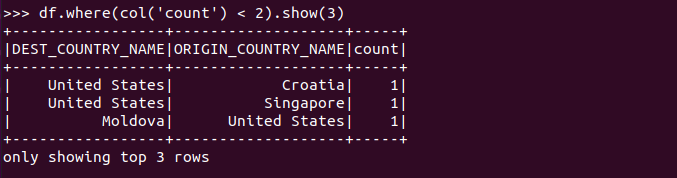

* 다중 조건을 사용하여 and필터와 or필터 사용 가능

In [ ]:
# and 필터 (&)
df.where((df['DEST_COUNTRY_NAME'] == 'United States')
            & (df['ORIGIN_COUNTRY_NAME'] == 'South Korea')).show()


# or 필터 (|)
df.where((df['DEST_COUNTRY_NAME'] == 'United States')
            | (df['ORIGIN_COUNTRY_NAME'] == 'South Korea')).show(3)

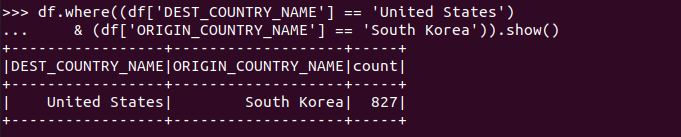

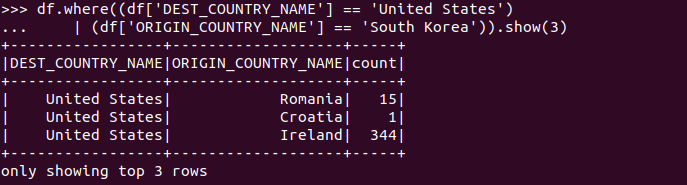

### 고유한 Row 얻기
* distinct()메소드를 사용, 하나 이상의 컬럼을 적용하여 중복되지 않은 고유한 row들을 추출 가능

In [ ]:
# 컬럼의 고유값 확인
df.select(col('DEST_COUNTRY_NAME')).distinct().show(5)

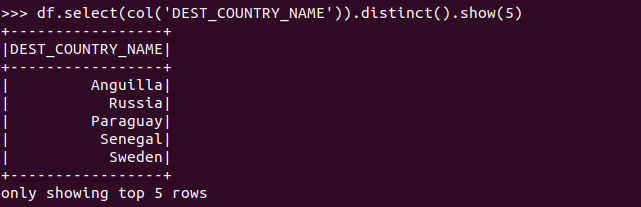

In [ ]:
# 2개 이상의 컬럼에 대하여 중복 없는 고유한 Row 확인
# DEST_COUNTRY_NAME 컬럼과 ORIGIN_COUNTRY_NAME에 대한 고유 Row 갯수 확인
df.select(col('DEST_COUNTRY_NAME'), col('ORIGIN_COUNTRY_NAME')).distinct().count()

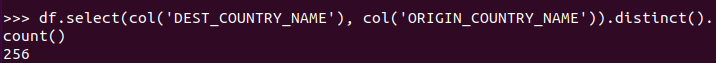

### Row 추가하기 & 합치기
* union()메소드를 사용해 원본 데이터에 새로운 Row를 추가 가능

In [ ]:
# 새로운 Row로 구성된 DataFrame 생성
from pyspark.sql import Row

schema = df.schema

newRows = [
    Row('New Country', 'Other Country', 5),
    Row('New Country 2', 'Other Country 3', 1)
]

parallelizedRows = spark.sparkContext.parallelize(newRows)
newDF = spark.createDataFrame(parallelizedRows, schema)

newDF.show()

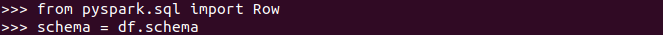

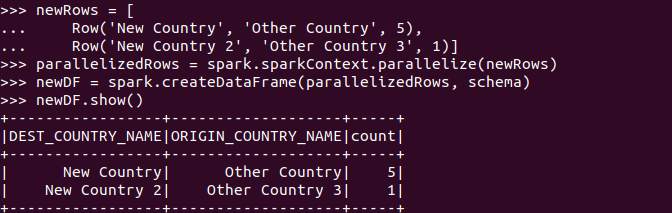

* tail(): DataFrame의 끝에서부터 n개를 list로 반환

In [ ]:
# 끝에서 3개의 데이터 반환
df.union(newDF).tail(3)

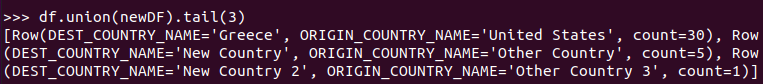

* 필터를 사용하여 두 DataFrame에서 조건에 부합하는 Row만 추출 가능

In [ ]:
df.union(newDF)\
    .where('count=1')\
    .where(df['ORIGIN_COUNTRY_NAME'] != 'United States')\
    .show()

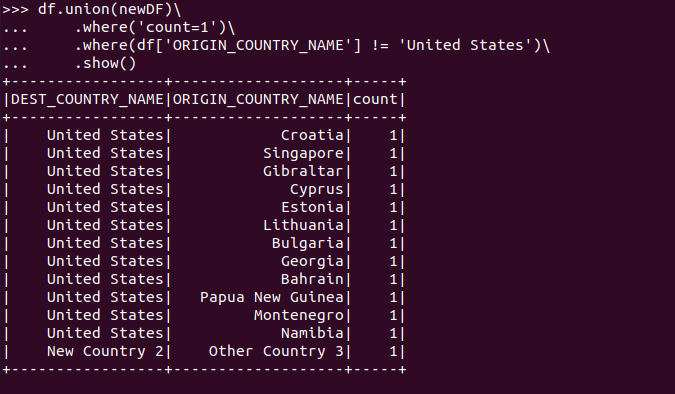

### Row 정렬하기

* sort()와 orderBy()메소드를 사용하여 DataFrame을 오름차순 또는 내림차순으로 정렬 가능
* orderBy()메소드 내부에서 sort()를 호출하므로, 두 메소드는 완전히 동일하게 작동
* 컬럼 표현식, 문자열 모두 사용 가능하며 다수의 컬럼에 대해서도 정렬 가능
* 기본 정렬 방식은 오름차순(ascending)

In [ ]:
# 오름차순 정렬
df.sort('count').show(5)

# 내림차순 정렬
df.sort('count', ascending = False).show(5)

* 오름차순

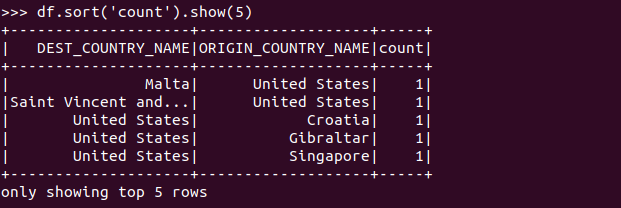

* 내림차순

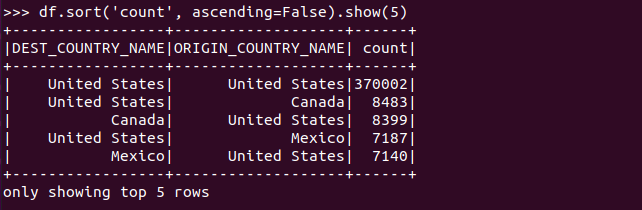

* 다수의 컬럼에 대한 정렬

In [ ]:
# count, DEST_COUNTRY_NAME 컬럼 기준으로 오름차순 정렬
# 둘은 동일한 결과 반환
df.orderBy('count', expr('DEST_COUNTRY_NAME')).show(5)
df.orderBy(col('count'), df['DEST_COUNTRY_NAME']).show(5)

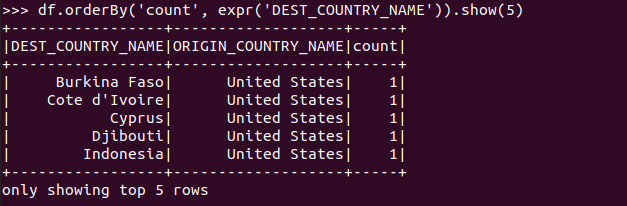

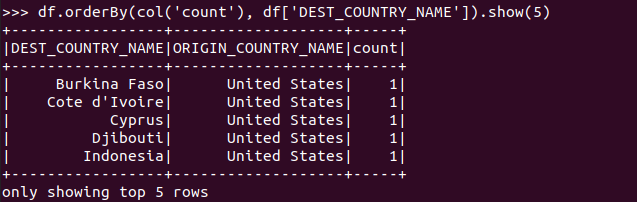

* 컬럼별로 오름차순/내림차순을 다르게 정렬 가능

In [ ]:
from pyspark.sql.functions import asc, desc
# 동잏한 결과를 반환한다
df.sort(col('count'),desc(), df['DEST_COUNTRY_NAME'].asc()).show(5)
df.sort(desc('count'), asc(col('DEST_COUNTRY_NAME'))).show(5)

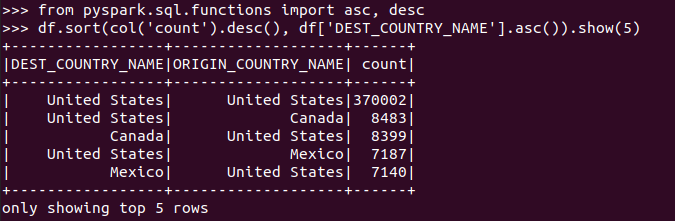

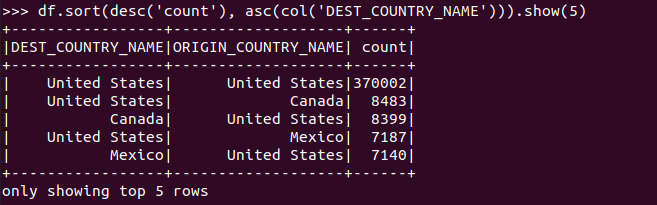

### When을 사용한 값 수정

* withColumn()과 when()을 사용하여 값 수정 가능
* DataFrame은 불변성을 지니므로 정확히는 값이 수정된 새로운 DataFrame을 생성하는 것
* when():SQL의 'CASE WHEN'과 유사하게 작동하며 조건에 부합할 때 값을 변환<br>
    1) 조건문으로 사용할 boolean 표현식, 2. 조건이 참일 때 반환할 값을 인자로 전달
    - when()과 otherwise()를 체인으로 연결하여 다양한 조건을 체크 가능
    - otherwise(): when()이 거짓일 때 적용할 값 지정

In [ ]:
# 원 데이터값 확인
df.where(col('DEST_COUNTRY_NAME') == 'South Korea').show()

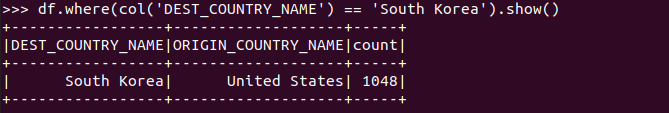

In [ ]:
from pyspark.sql.functions import when

# when()과 otherwise()를 사용하여
# 'DEST_COUNTRY_NAME'에서 South Korea를 Republic Of Korea로,
# 'ORIGIN_COUNTRY_NAME'에서 United States를 USA로 변환한 신규 DataFrame인 df2 생성
df2 = withColumn('DEST_COUNTRY_NAME',
                when(col('DEST_COUNTRY_NAME') == 'South Korea', 'Republic Of Korea')
                .otherwise(col('DEST_COUNTRY_NAME')))\
            .withColumn('ORIGIN_COUNTRY_NAME',
                when(col('ORIGIN_COUNTRY_NAME') == 'United States', 'USA')
                .otherwise(col('ORIGIN_COUNTRY_NAME')))\
            .withColumn('count', col('count'))

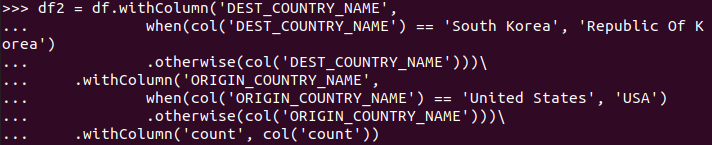

In [ ]:
# 결과 확인
df2.where(col('DEST_COUNTRY_NAME') == 'Republic Of Korea').show()

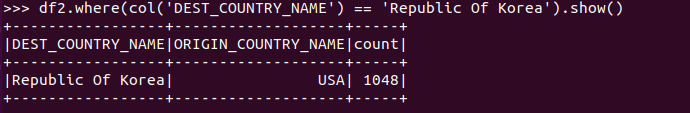

### 그룹화

In [ ]:
# 유통 물류 데이터 다운로드
# 다른 우분투 터미널에서 실행
wget https://github.com/FVBros/Spark-The-Definitive-Guide/raw/master/data/retail-data/all/online-retail-dataset.csv

In [ ]:
# 다시 Spark 환경에서 입력
# 데이터 로드
retail_df = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('/home/ubuntu/online-retail-dataset.csv')

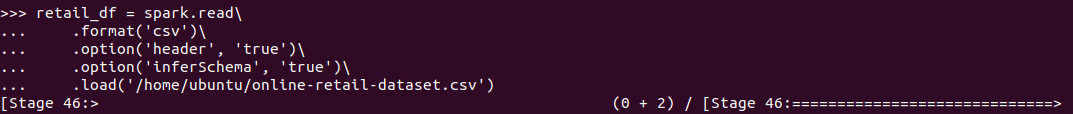

In [ ]:
# 스키마 확인
retail_df.printSchema()

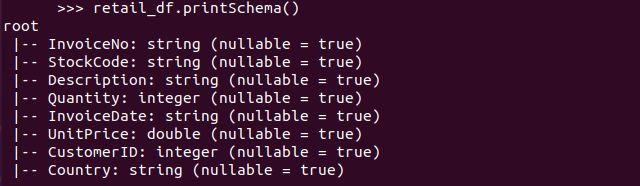

In [ ]:
# DataFrame 형태로 출력
retail_df.show(3)

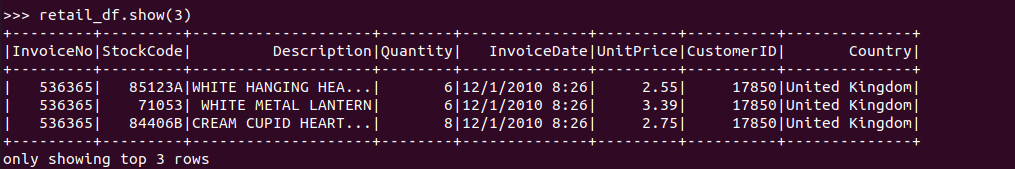

* groupBy(): 메소드를 사용하여 그룹화 작업 수행 가능<br>
    - 그룹화 작업은 크게 두 단계로 이뤄진다.
        1. 첫 번째 단계: 컬럼 그룹화 후 RelationalGroupedDataset 반환
        2. 두 번째 단계: 집계 연산을 수행한 후 DataFrame 반환
    - 두 가지 이상 컬럼을 기준으로 한 그룹화

In [ ]:
from pyspark.sql.functions import count

# InvoiceNo, CustomerID를 기준으로 그룹화
# groupBy()로 RelationalGroupedDataset 반환
# count()를 통해 집계 연산 수행
retail_df.groupBy('InvoiceNo', 'CustomerID').count().show(5)

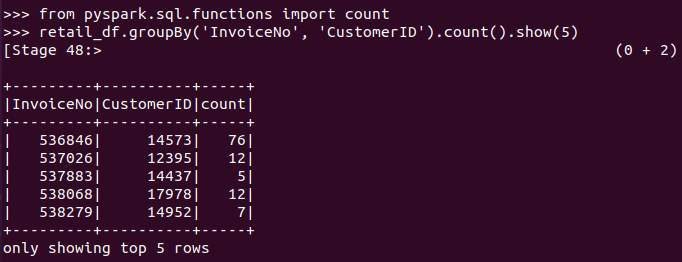

* agg()를 사용하면 두 가지 이상의 집계연산이 지정 가능, 기존의 메소드 방식(count()를 사용한 집계 연산)과 함께 표현식 또한 사용 가능
* stddev_pop(): 컬럼 전체 모집단에 대한 표준편차(standard deviation of population)계산

In [ ]:
retail_df.groupBy('InvoiceNo').agg(
    count('Quantity').alias('quan'),
    expr('count(Quantity)'),
    expr('avg(Quantity)'),
    expr('stddev_pop(Quantity)')).show(5)

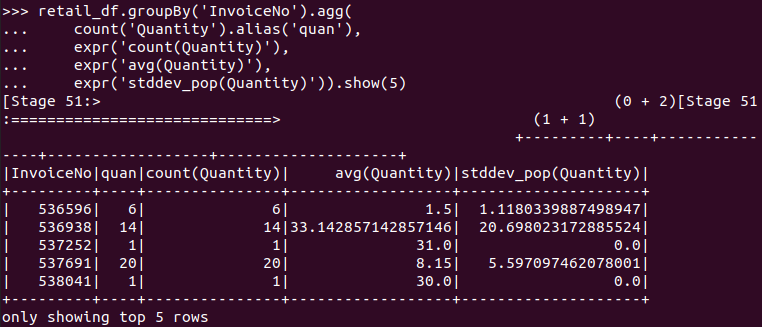

### 사용자 정의 함수(User Defination Function, UDF)

* Spark의 Spark SQL API는 기본적으로 pyspark.sql패키지에 존재하는 타입과 함수들만 이용 가능
* 하지만 UDF를 작성하여 Python이나 Scala, 외부 라이브러리를 사용해 사용자가 원하는 형태의 transformation을 만들 수 있다.
* 강력하지만 Spark 외부방식을 이용함으로써 프로세스 부하 및 성능 저하가 발생할 수 있다.
* UDF를 사용하기 위해서 먼저 Spark가 해당 프로그래밍 언어의 함수를 인식할 수 있어야 하며, 다음으로 UDF를 Spark에 추가적으로 등록해야 함

In [ ]:
#  UDF 생성을 위해 먼저 실제 함수 필요
# 숫자 입력 시 세제곱 값을 반환하는 python 사용자 함수 power3 작성
def power3(double_value):
    return double_value ** 3

power3(2.0)

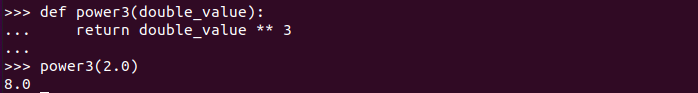

In [ ]:
# 다음으로 모든 워커 노드에서 생성한 함수를 사용할 수 있도록 Spark에 등록
from pyspark.sql.functions import udf

# 등록이 완료되면 Spark에서 udf 사용 가증
power3udf = udf(power3)

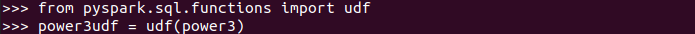

In [ ]:
# 데이터 생성
udfExampleDF = spark.range(5).toDF('num')
udfExampleDF.show()

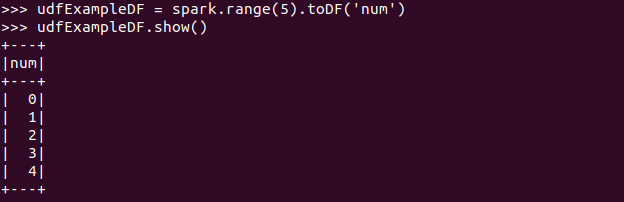

In [ ]:
# UDF(power3udf) 적용
udfExampleDF.select(power3udf(col('num')).alias('power3_num')).show()

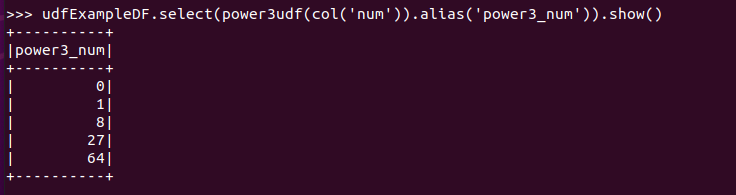

## 3. Spark SQL

* 프로그래밍 측면에서 Spark SQL은 스키마를 가진 구조화/반구조화 데이터에 대하여 SQL호환 질의를 적용할 수 있게 해줌
* pyspark.sql이 Spark SQL의 python 패키지이다.
* Spark 1.3에서 도입 이후로 Spark SQL은 수많은 고수준 구조화 기능과 스택들을 갖추고 있는 방대한 엔진으로 진화해옴

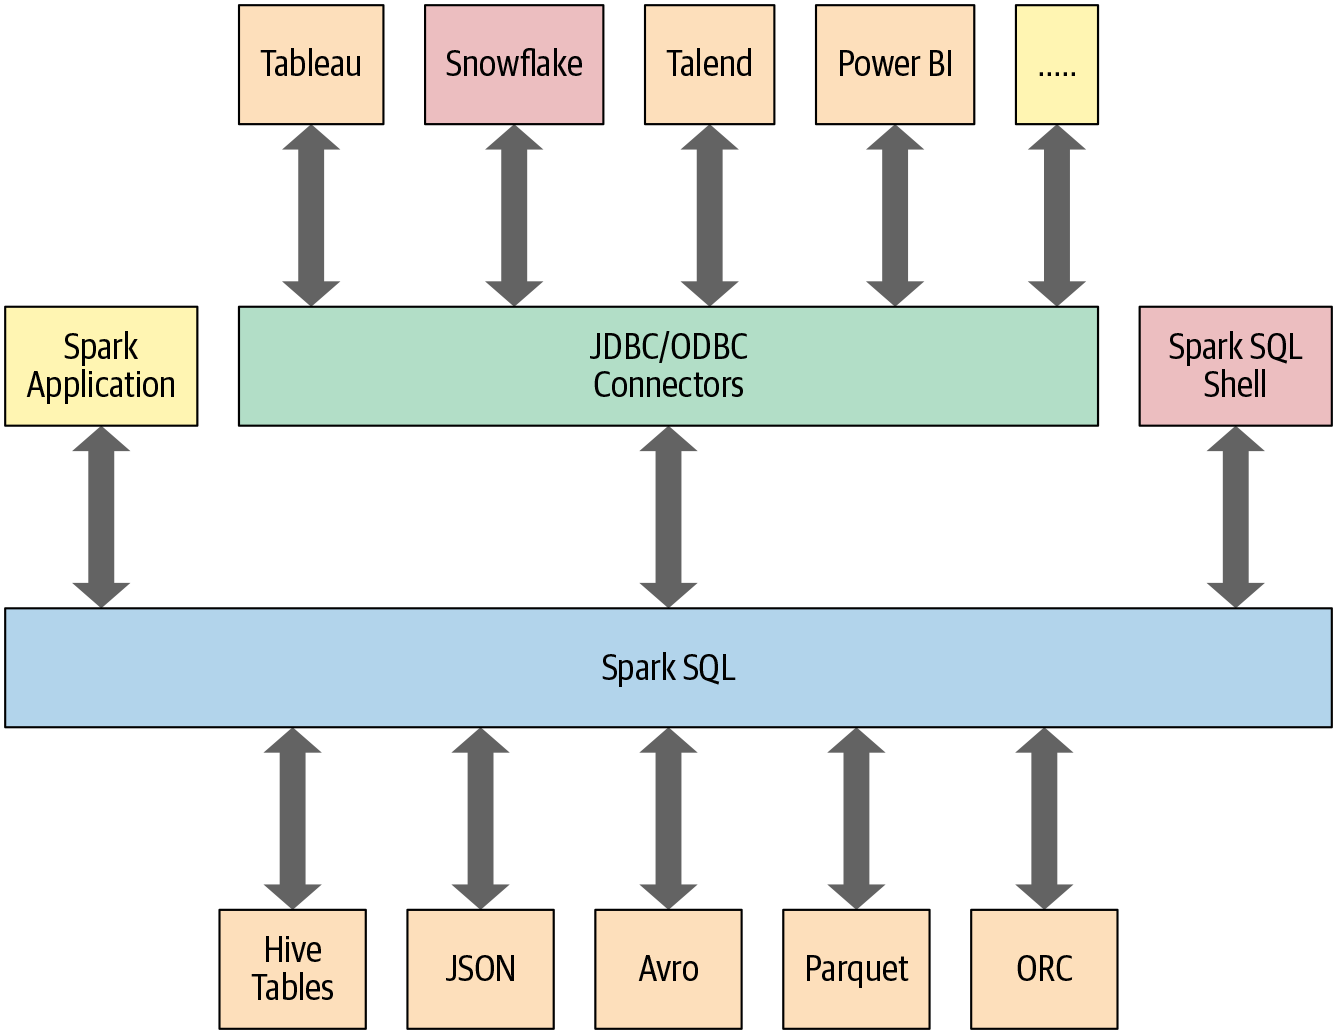

### 주요 기능

* **SQL 지원**: 표준SQL쿼리릏 사용하여 데이터를 읽고 쓸 수 있음
* **DataFrame API 지원**: Python, Java, Scala, R등 다양한 언어에서 사용할 수 있는 DataFrame과 Dataset API 제공
* **통합성**: SQL쿼리와 Spark의 프로그래밍이 서로 통합되어, SQL쿼리를 Spark내에서 사용하거나, Spark를 사용한 데이터 처리를 SQL쿼리 내에서 사용할 수 있음
* **결합 연산 최적화**: Catalyst Optimizer를 통해 데이터베이스에서의 고급 최적화 기법을 사용 가능
* Spark SQL엔진의 핵심에는 쿼리 최적화를 위한 Catalyst Optimizer와 메모리 관리/실행 성능 개선을 위한 Project Tungsten 존재

In [ ]:
# hive관련 오류를 없애기위한 세션 초기화
# 여기선 오류를 무시하고 진행하였다
from pyspark.sql import SparkSession

spark.stop()

spark = SparkSession.builder\
    .appName('SparkEx')
    .enableHiveSupport() \
    .getOrCreate()

In [ ]:
# 데이터베이스 확인
spark.sql("SHOW DATABASES").show()

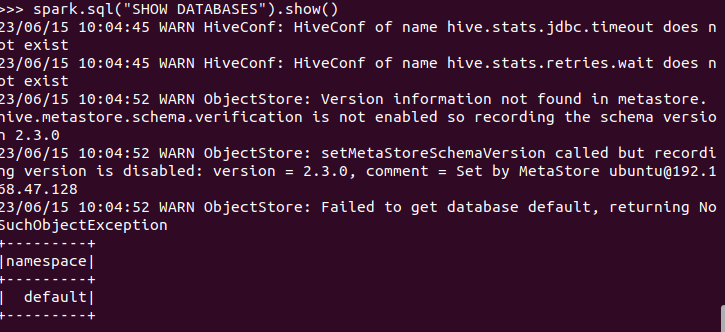

In [ ]:
# 새 데이터베이스 생성
spark.sql("create database spark_db")

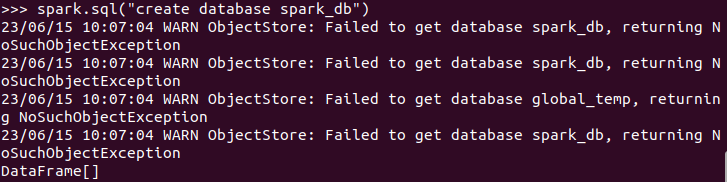

In [ ]:
# 데이터베이스 삭제
# CADCADE: 참조 관계(기본키와 외래키 관계)가 있을 경우 참조되는 데이터도 자동으로 삭제 가능
spark.sql("drop database spark_db CASCADE")

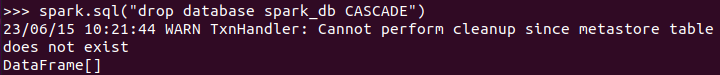

In [ ]:
# 생성된 데이터베이스 확인
spark.sql("SHOW DATABASES").show()

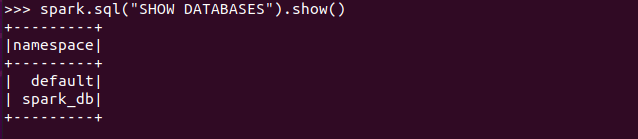

In [ ]:
# spark_db 데이터베이스를 사용
spark.sql("use spark_db")

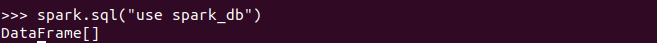

In [ ]:
# spark_db데이터베이스 내에 생성된 테이블 확인
# 테이블 생성 전이므로 아무것도 뜨지 않는다
spark.sql("SHOW TABLES IN spark_db").show()

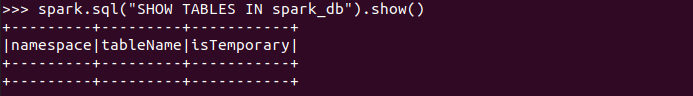

In [ ]:
# 테이블 생성
spark.sql("""CREATE TABLE spark_db.GRADE (Sno INT NOT NULL, Cno STRING, Cname STRING, Grade STRING, Score INT NOT NULL)""")

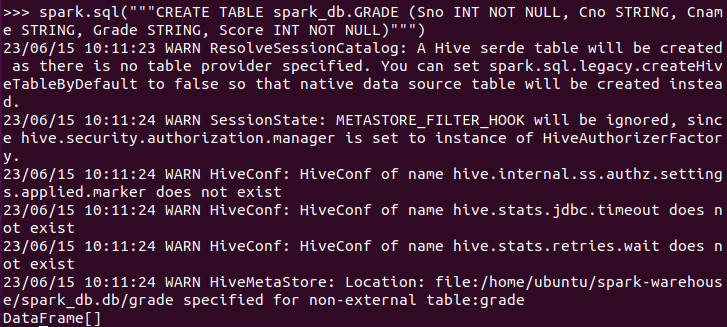

In [ ]:
# 생성된 테이블 확인
spark.sql("SHOW TABLES IN spark_db").show()

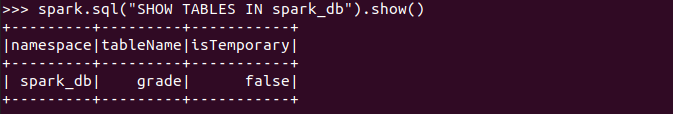

In [ ]:
# GRADE테이블의 정보 추출
spark.sql("""select * from GRADE""").show()

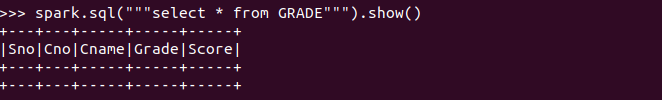

In [ ]:
# 테이블에 데이터 추가
spark.sql("""INSERT INTO GRADE VALUES (2001, 'A1000', 'structure', 'A', 91)""")
spark.sql("""INSERT INTO GRADE VALUES (2002, 'A2000', 'structure', 'A+', 99)""")

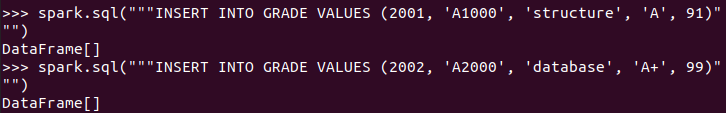

In [ ]:
# 추가 후 테이블 확인
spark.sql("""select * from GRADE""").show()

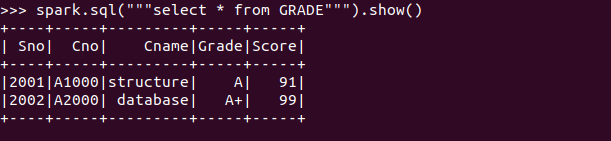

In [ ]:
# GRADE 테이블 삭제
spark.sql("""drop table GRADE""")

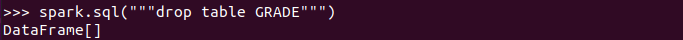